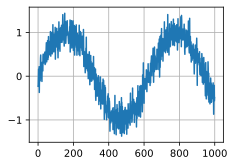

In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torch.nn as nn

T = 1000  # Generate a total of 1000 points
time = torch.arange(0.0, T)
x = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
d2l.plot(time, [x])

In [2]:
tau = 4
features = d2l.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i: T-tau+i]
labels = x[tau:]

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train],
                             labels[:n_train].reshape(-1, 1)),
                            batch_size, is_train=True)

# Function for initializing the weights of net
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

# Vanilla MLP architecture
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# Least mean squares loss
loss = nn.MSELoss()

In [3]:
def train_net(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(1, epochs + 1):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train_net(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.068555
epoch 2, loss: 0.059158
epoch 3, loss: 0.051361
epoch 4, loss: 0.049442
epoch 5, loss: 0.050736
epoch 6, loss: 0.050067
epoch 7, loss: 0.048833
epoch 8, loss: 0.049579
epoch 9, loss: 0.049855
epoch 10, loss: 0.049433


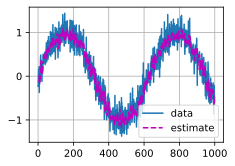

In [4]:
estimates = net(features)
d2l.plot([time, time[tau:]], [x, estimates.detach()],
         legend=['data', 'estimate'])

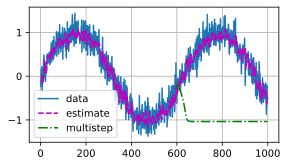

In [5]:
predictions = d2l.zeros(T)
predictions[:n_train] = x[:n_train]
for i in range(n_train, T):
    predictions[i] = net(
        predictions[(i-tau):i].reshape(1, -1)).reshape(1)
d2l.plot([time, time[tau:], time[n_train:]],
         [x, estimates.detach(), predictions[n_train:].detach()],
         legend=['data', 'estimate', 'multistep'], figsize=(4.5, 2.5))

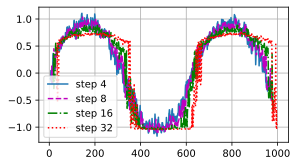

In [6]:
k = 33  # Look up to k - tau steps ahead

features = d2l.zeros((k, T-k))
for i in range(tau):  # Copy the first tau features from x
    features[i] = x[i:T-k+i]

for i in range(tau, k):  # Predict the (i-tau)-th step
    features[i] = net(features[(i-tau):i].T).T

steps = (4, 8, 16, 32)
d2l.plot([time[i:T-k+i] for i in steps], [features[i].detach() for i in steps],
         legend=[f'step {i}' for i in steps], figsize=(4.5, 2.5))

In [7]:
import collections
from d2l import torch as d2l
import re

In [8]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """Load the time machine book into a list of sentences."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line.strip().lower())
            for line in lines]

lines = read_time_machine()
f'# sentences {len(lines)}'

'# sentences 3221'

In [9]:
def tokenize(lines, token='word'):  #@save
    """Split sentences into word or char tokens."""
    if token == 'word':
        return [line.split(' ') for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type '+token)

tokens = tokenize(lines)
tokens[0:2]

[['the', 'time', 'machine', 'by', 'h', 'g', 'wells', ''], ['']]

In [10]:
class Vocab:  #@save
    def __init__(self, tokens, min_freq=0, reserved_tokens=None):
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[0])
        self.token_freqs.sort(key=lambda x: x[1], reverse=True)
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(sentences):  #@save
    # Flatten a list of token lists into a list of tokens
    tokens = [tk for line in sentences for tk in line]
    return collections.Counter(tokens)

In [11]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[0:10])

[('<unk>', 0), ('the', 1), ('', 2), ('i', 3), ('and', 4), ('of', 5), ('a', 6), ('to', 7), ('was', 8), ('in', 9)]


In [12]:
for i in range(8, 10):
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him', '']
indices: [1, 20, 72, 17, 38, 12, 120, 43, 706, 7, 660, 5, 112, 2]
words: ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
indices: [8, 1654, 6, 3864, 634, 7, 131, 26, 344, 127, 484, 4]


In [13]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    corpus = [vocab[tk] for line in tokens for tk in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(171489, 28)

In [14]:
from d2l import torch as d2l
import torch
import random

tokens = d2l.tokenize(d2l.read_time_machine())
vocab = d2l.Vocab(tokens)
print(vocab.token_freqs[:10])

[('the', 2261), ('', 1282), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443)]


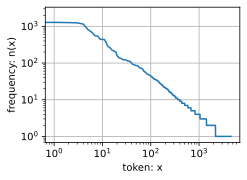

In [15]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [16]:
bigram_tokens = [[pair for pair in zip(
    line[:-1], line[1:])] for line in tokens]
bigram_vocab = d2l.Vocab(bigram_tokens)
print(bigram_vocab.token_freqs[:10])

[(('of', 'the'), 297), (('in', 'the'), 161), (('i', 'had'), 126), (('and', 'the'), 104), (('i', 'was'), 104), (('the', 'time'), 97), (('it', 'was'), 94), (('to', 'the'), 81), (('as', 'i'), 75), (('of', 'a'), 69)]


In [17]:
trigram_tokens = [[triple for triple in zip(line[:-2], line[1:-1], line[2:])]
                  for line in tokens]
trigram_vocab = d2l.Vocab(trigram_tokens)
print(trigram_vocab.token_freqs[:10])

[(('the', 'time', 'traveller'), 53), (('the', 'time', 'machine'), 24), (('the', 'medical', 'man'), 22), (('it', 'seemed', 'to'), 14), (('it', 'was', 'a'), 14), (('i', 'began', 'to'), 13), (('i', 'did', 'not'), 13), (('i', 'saw', 'the'), 13), (('here', 'and', 'there'), 12), (('i', 'could', 'see'), 12)]


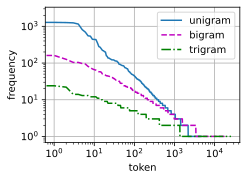

In [18]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token',
         ylabel='frequency', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [19]:
#@save
def seq_data_iter_random(corpus, batch_size, num_steps):
    # Offset the iterator over the data for uniform starts
    corpus = corpus[random.randint(0, num_steps):]
    # Subtract 1 extra since we need to account for label
    num_examples = ((len(corpus) - 1) // num_steps)
    example_indices = list(range(0, num_examples * num_steps, num_steps))
    random.shuffle(example_indices)

    def data(pos):
        # This returns a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    # Discard half empty batches
    num_batches = num_examples // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # `batch_size` indicates the random examples read each time
        batch_indices = example_indices[i:(i+batch_size)]
        X = [data(j) for j in batch_indices]
        Y = [data(j + 1) for j in batch_indices]
        yield torch.Tensor(X), torch.Tensor(Y)

In [20]:
my_seq = list(range(30))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y)

X:  tensor([[12., 13., 14., 15., 16., 17.],
        [ 0.,  1.,  2.,  3.,  4.,  5.]]) 
Y: tensor([[13., 14., 15., 16., 17., 18.],
        [ 1.,  2.,  3.,  4.,  5.,  6.]])
X:  tensor([[18., 19., 20., 21., 22., 23.],
        [ 6.,  7.,  8.,  9., 10., 11.]]) 
Y: tensor([[19., 20., 21., 22., 23., 24.],
        [ 7.,  8.,  9., 10., 11., 12.]])


In [21]:
#@save
def seq_data_iter_consecutive(corpus, batch_size, num_steps):
    # Offset for the iterator over the data for uniform starts
    offset = random.randint(0, num_steps)
    # Slice out data: ignore `num_steps` and just wrap around
    num_indices = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.Tensor(corpus[offset:offset+num_indices])
    Ys = torch.Tensor(corpus[offset+1:offset+1+num_indices])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches * num_steps, num_steps):
        X = Xs[:, i:(i+num_steps)]
        Y = Ys[:, i:(i+num_steps)]
        yield X, Y

In [22]:
for X, Y in seq_data_iter_consecutive(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 6.,  7.,  8.,  9., 10., 11.],
        [17., 18., 19., 20., 21., 22.]]) 
Y: tensor([[ 7.,  8.,  9., 10., 11., 12.],
        [18., 19., 20., 21., 22., 23.]])


In [23]:
#@save
class SeqDataLoader:
    """A iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_consecutive
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [24]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [25]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [26]:
X = torch.arange(10).reshape(2, 5)
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [27]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = d2l.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = d2l.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [28]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (d2l.zeros((batch_size, num_hiddens), device=device), )

In [29]:
def rnn(inputs, state, params):
    # Inputs shape: (num_steps, batch_size, vocab_size)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [30]:
#@save
class RNNModelScratch:
    """A RNN Model based on scratch implementations."""

    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward

    def __call__(self, X, state):
        X = F.one_hot(X.T.long(), self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [31]:
num_hiddens, device = 512, d2l.try_gpu()
model = RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                        init_rnn_state, rnn)
state = model.begin_state(X.shape[0], device)
Y, new_state = model(X.to(device), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [32]:
#@save
def predict_ch8(prefix, num_predicts, model, vocab, device):
    state = model.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]

    def get_input():
        return torch.tensor([outputs[-1]], device=device).reshape(1, 1)
    for y in prefix[1:]:  # Warmup state with prefix
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_predicts):  # Predict num_predicts steps
        Y, state = model(get_input(), state)
        outputs.append(int(Y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [33]:
predict_ch8('time traveller ', 10, model, vocab, device)

'time traveller vxoacglsqk'

In [34]:
#@save
def grad_clipping(model, theta):
    if isinstance(model, nn.Module):
        params = [p.data for p in model.parameters() if p.requires_grad]
    else:
        params = model.params

    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [35]:
#@save
def train_epoch_ch8(model, train_iter, loss, updater, device,
                    use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # loss_sum, num_examples
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize state when either it is the first iteration or
            # using random sampling.
            state = model.begin_state(batch_size=X.shape[0], device=device)
        else:
            for s in state:
                s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        py, state = model(X, state)
        l = loss(py, y.long()).mean()

        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(model, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(model, 1)
            updater(batch_size=1)  # Since used mean already

        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

In [36]:
#@save
def train_ch8(model, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    # Initialize
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[1, num_epochs])
    if isinstance(model, nn.Module):
        trainer = torch.optim.SGD(model.parameters(), lr)

        def updater(batch_size):
            return trainer.step()
    else:
        def updater(batch_size):
            return d2l.sgd(model.params, lr, batch_size)

    def predict(prefix):
        return predict_ch8(prefix, 50, model, vocab, device)

    # Train and check the progress.
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            model, train_iter, loss, updater, device, use_random_iter)
        if epoch % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.2, 16000.0 tokens/sec on cpu
time traveller filly foom shal aplis th tice theo  in thi grougt
traveller filby but an his ditensilts hec ners stwa d are a


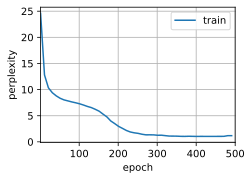

In [37]:
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.3, 9781.5 tokens/sec on cpu
time traveller  you can show black is white by argument said fil
traveller smiled round at us then still smiling faintly and


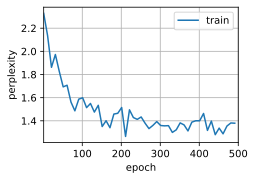

In [38]:
train_ch8(model, train_iter, vocab, lr, num_epochs, device,
          use_random_iter=True)